In [47]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [48]:
grabCut = cv.cvtColor(cv.imread(r"grabCut.jpg"), cv.COLOR_BGR2RGB)
threshold = cv.cvtColor(cv.imread(r"threshold.jpg"), cv.COLOR_BGR2RGB)
kmeans = cv.cvtColor(cv.imread(r"kmeans.jpg"), cv.COLOR_BGR2RGB)


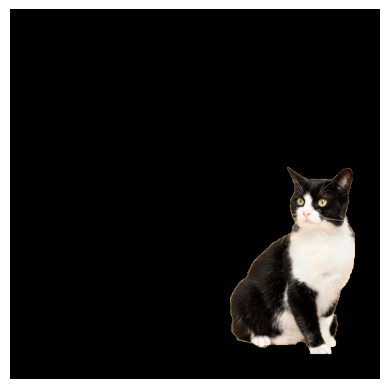

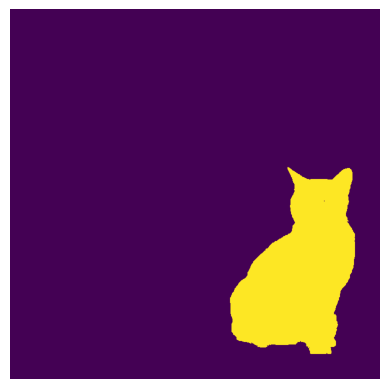

In [49]:
ptohoMask = np.zeros(grabCut.shape[:2], dtype="uint8")
bgdModel = np.zeros((1, 65), dtype="float64")
fgdModel = np.zeros((1, 65), dtype="float64")

rect = (50, 50, grabCut.shape[1]-100, grabCut.shape[0]-100)

cv.grabCut(grabCut, ptohoMask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)

ptohoMask2 = np.where((ptohoMask==2)|(ptohoMask==0), 0, 1).astype("uint8")
grabCut_nobg = grabCut * ptohoMask2[:, :, np.newaxis]

plt.imshow(grabCut_nobg)
plt.axis('off')
plt.show()

plt.imshow(ptohoMask2)
plt.axis('off')
plt.show()

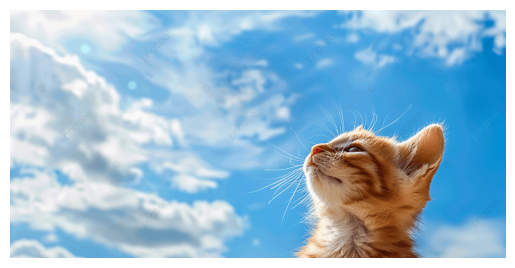

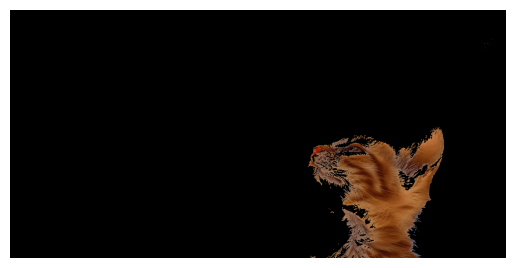

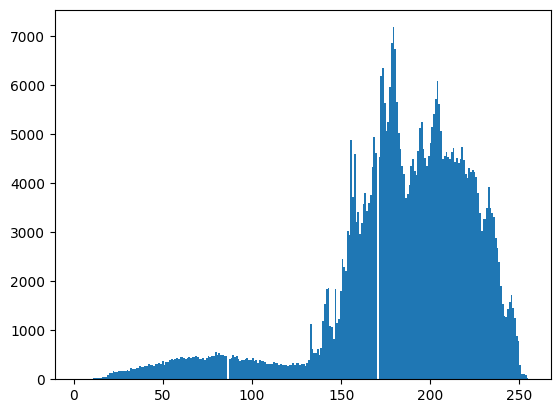

In [50]:
thresholdImage = cv.cvtColor(threshold, cv.COLOR_BGR2GRAY)
_, thresholdMask = cv.threshold(thresholdImage, 120, 255, cv.THRESH_BINARY_INV)
plt.axis("off")
plt.imshow(threshold)
plt.show()
resultThresholdImage = cv.bitwise_and(threshold, threshold, mask=thresholdMask)
plt.axis("off")
plt.imshow(resultThresholdImage)
plt.show()
plt.hist(thresholdImage.ravel(), 256)
plt.show()


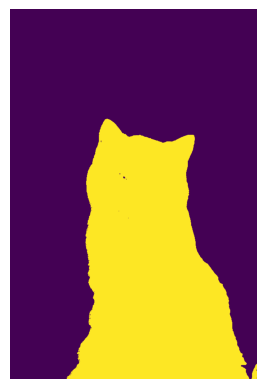

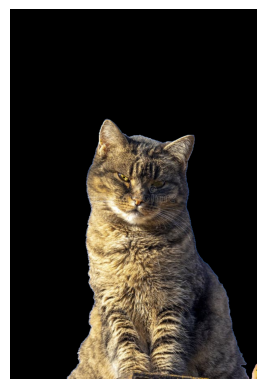

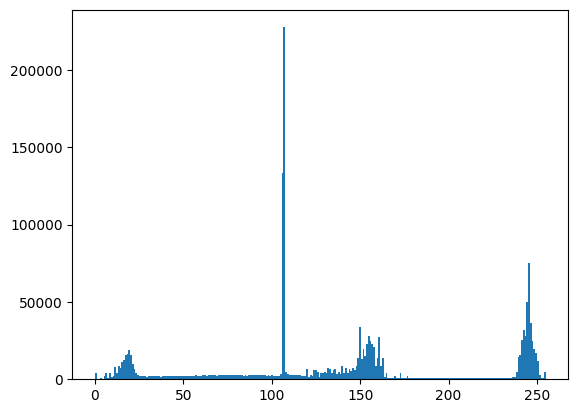

In [ ]:
hsv = cv.cvtColor(kmeans, cv.COLOR_RGB2HSV)

Z = hsv.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3

ret, label, center = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

labels2D = label.reshape((kmeans.shape[0], kmeans.shape[1]))

counts = np.bincount(label.flatten())
bg_label = np.argmax(counts)

mask1 = np.where(labels2D == bg_label, 0, 1).astype("uint8")

plt.imshow(mask1)
plt.axis('off')
plt.show()

res1 = kmeans * mask1[:, :, np.newaxis]
plt.imshow(res1)
plt.axis('off')
plt.show()



In [52]:
def Dice(autoMask, manualMaskPath, name):
    # загрузка ручной маски
    manualMask = cv.imread(manualMaskPath, cv.IMREAD_GRAYSCALE)
    if manualMask is None:
        raise ValueError("Не удалось загрузить manual mask")

    # приведение размеров
    if autoMask.shape != manualMask.shape:
        manualMask = cv.resize(
            manualMask,
            (autoMask.shape[1], autoMask.shape[0]),
            interpolation=cv.INTER_NEAREST
        )

    autoBin = autoMask.copy()
    if autoBin.max() <= 1.0:   # если нормализовано
        autoBin = (autoBin * 255).astype(np.uint8)

    # жёсткая бинаризация обеих масок
    _, autoBin = cv.threshold(autoBin, 127, 255, cv.THRESH_BINARY)
    _, manualBin = cv.threshold(manualMask, 127, 255, cv.THRESH_BINARY)

    # перевод в bool
    autoBool = autoBin > 0
    manualBool = manualBin > 0

    # Dice
    intersection = np.logical_and(autoBool, manualBool).sum()
    areaA = autoBool.sum()
    areaB = manualBool.sum()

    if areaA + areaB == 0:
        dice = 1.0  # обе маски пустые — полное совпадение
    else:
        dice = 2.0 * intersection / (areaA + areaB)

    # отображение
    plt.axis("off")
    plt.imshow(autoBool)
    plt.show()

    plt.axis("off")
    plt.imshow(manualBool)
    plt.show()

    print(f"Коэффициент Дайса для {name}: {dice:.14f}")

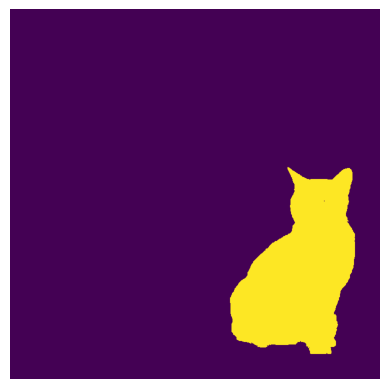

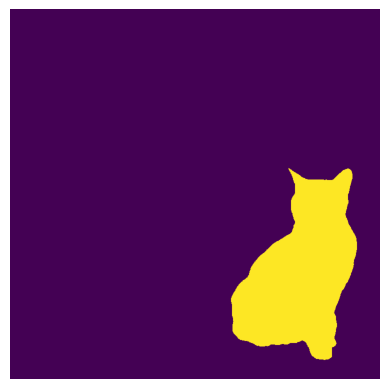

Коэффициент Дайса для GrabCut: 0.98389023017639


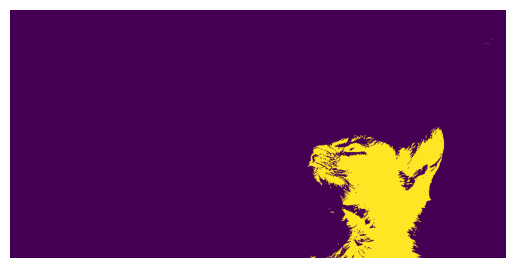

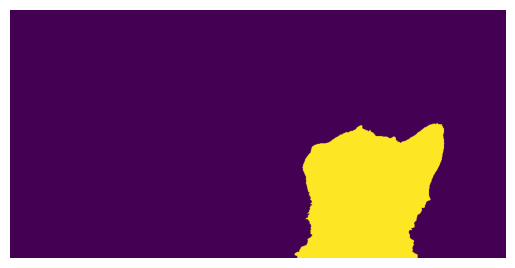

Коэффициент Дайса для Treshold: 0.78344631532911


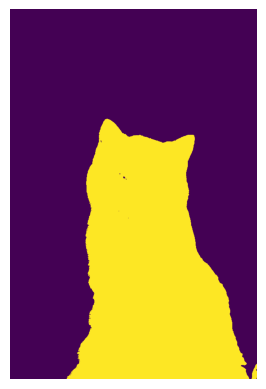

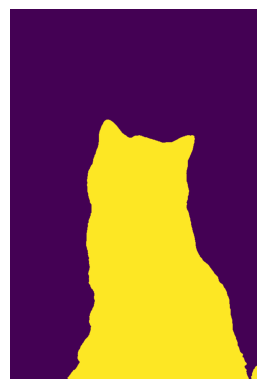

Коэффициент Дайса для K-means: 0.99565804953604


In [53]:
Dice(ptohoMask2, "grabCutManual.jpg", "GrabCut")
Dice(thresholdMask, "thresholdManual.jpg", "Treshold")
Dice(mask1, "kmeansManual.jpg", "K-means")